In [1]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from a2c.model import Policy
from microgrid import MG

In [52]:
#import torch.optim as optim
env = MG(True,True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)
#policy = A2C(args, net, optimizer, device)
checkpoint = torch.load('./models/user_first/best')
actor_critic.base.load_state_dict(checkpoint['model_state_dict'],strict=False)
actor_critic.base.eval()

Network(
  (gru): GRU(20, 128)
  (actor): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (mean): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (std): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (critic): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [53]:
observations = np.zeros([12*24,env.observation_space.shape[0]])
T_AC = np.zeros([12*24,10])
E_EV = np.zeros([12*24,5])
costs = np.zeros([12*24,16])
env.seed(1)
obs = env.reset()
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=0
while done == False:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, infos = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    T_AC[i] = env.ACs_T
    E_EV[i] = env.EVs_demand
    costs[i] = cost
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)
    #obs = eval_envs.partial_reset(done)
#eval_envs.close()

In [54]:
costs.sum(axis=0)

array([-45.22844585,  -0.45543887,  -0.77356745,  -0.57911809,
        -0.37914123,  -2.09318277,  -7.86071073,  -5.70423675,
        -4.32558951,  -3.78225376,  -4.72028641,  -6.46789566,
        -7.24298291,  -6.98170854,  -8.16660102,  -5.70776188])

In [55]:
costs.sum()

-110.46892143223239

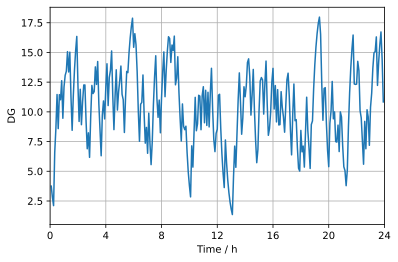

In [56]:
plt.plot(observations[:-1,0],observations[:-1,2])
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('DG')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

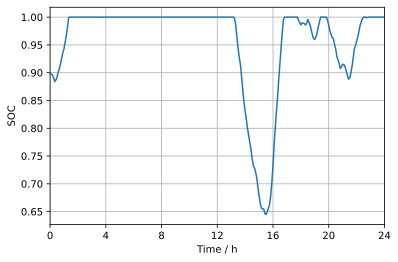

In [57]:
plt.plot(observations[:-1,0],observations[:-1,3])
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('SOC')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

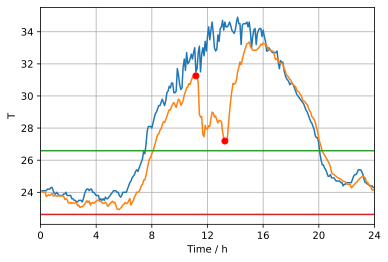

In [66]:
n=6
plt.plot(observations[:-1,0],observations[:-1,4])
plt.plot(observations[:-1,0],T_AC[:-1,n])
plt.plot(env.ACs_start[n]/12, T_AC[int(env.ACs_start[n]),n], 'ro')
plt.plot(env.ACs_end[n]/12, T_AC[int(env.ACs_end[n]),n], 'ro')
plt.plot(observations[:-1,0], env.ACs_parameter[3,n]*np.ones(12*24-1), label='Tmax')
plt.plot(observations[:-1,0], env.ACs_parameter[4,n]*np.ones(287), label='Tmin')
#plt.ylim(0,1.05)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('T')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()